In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
import seaborn
from os.path import join
%matplotlib inline

In [2]:
import h5py

def readH5DataFrame(h5Filename, h5GroupName):
    h5 = h5py.File(h5Filename, "r")
    h5Group = h5[h5GroupName]
    mapping = { k : h5Group[k][:] for k in h5Group }
    return pd.DataFrame.from_dict(mapping)

# 
#metricsH5 = "/home/UNIXHOME/dalexander/Projects/Bugs/Dromedary-HQRF/Ecoli-7799/X1E3_metrics.h5"
metricsH5 = "/tmp/X1E3_metrics.h5"

df =  readH5DataFrame(metricsH5, "MFMetrics")

In [3]:
from PRmm.model import Fixture
fx = Fixture.fromIniFile("/home/UNIXHOME/dalexander/Projects/Bugs/Dromedary-HQRF/Ecoli-7799/fixture.ini", "X1E3")

In [4]:
frameRateHz = 80.0

# Augment columns
df["HalfSandwichRate"] = df.NUM_HALF_SANDWICHES.astype(np.float) /  df.NUM_PULSES
df["PulseRate"] = df.NUM_PULSES.astype(np.float) / (df.NUM_FRAMES / frameRateHz)
df["LabelStutterRate"] = df.NUM_PULSE_LABEL_STUTTERS.astype(np.float) / df.NUM_PULSES

hns = df.ZmwNumber.unique()

In [12]:
def basicActivityPlot(hn, fx=None):
    fig = plt.figure(figsize=(6,10))
    
    dfZ = df[df.ZmwNumber==hn].copy()
    dfZ["BASE_END"] = dfZ.NUM_BASES.cumsum()

    if fx is None:
        hasAlignments = False
        hasHqRegion = False
    else:
        fxZ = fx[hn]
        hasAlignments = len(fxZ.alignments) > 0
        hasHqRegion = len(fxZ.baseRegions.hqRegion) > 0       
        
    # Resolve a (begin,end) extent in bases to an extent in windows,
    # using BASE_END
    def resolveBaseExtent(baseExtent):
        b, e = baseExtent
        return (dfZ.BASE_END.searchsorted(b), 
                dfZ.BASE_END.searchsorted(e))
        
    if hasHqRegion:
        hqExtent = resolveBaseExtent(fxZ.baseRegions.hqRegion.extent)

    if hasAlignments:
        alnExtents = [ resolveBaseExtent(aln.extent)
                       for aln in fxZ.baseRegions.alignments ]
        
    
    def makeSubplot(pane, metric, desc):
        plt.subplot(3, 1, pane)
        plt.plot(dfZ.BlockNumber, metric, 'o')
        ax = plt.gca()
        ax.set_xlim(0, len(dfZ))
        ymin, ymax = ax.get_ylim()
        #plt.vlines(alnExtent, *ax.get_ylim(), linewidth=1)
        #plt.vlines(hqExtent,  *ax.get_ylim(), linewidth=1, color="red")
        if hasAlignments:
            for alnExtent in alnExtents:
                plt.hlines(ymax, alnExtent[0], alnExtent[1], linewidth=16, color="red")
        if hasHqRegion:
            plt.hlines(ymin, hqExtent[0],  hqExtent[1],  linewidth=16, color="black")
        plt.ylabel(desc)
    
    makeSubplot(1, dfZ.LabelStutterRate, "Pulse homopolymer content")
    makeSubplot(2, dfZ.PulseRate,        "Pulse rate")
    makeSubplot(3, dfZ.HalfSandwichRate, "Half-sandwich rate")
    
    fig.suptitle(str(hn), size=14)

    

[ 0.  0.  0.  0.]


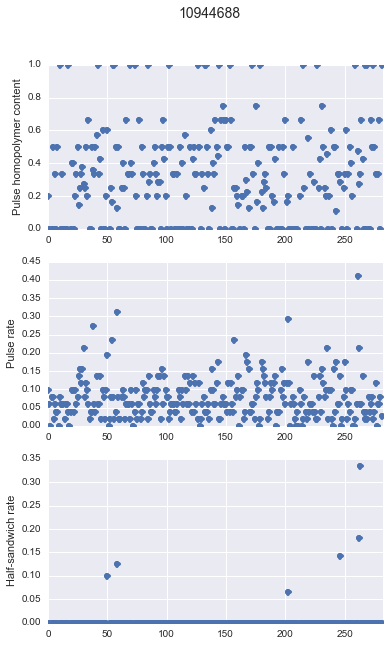

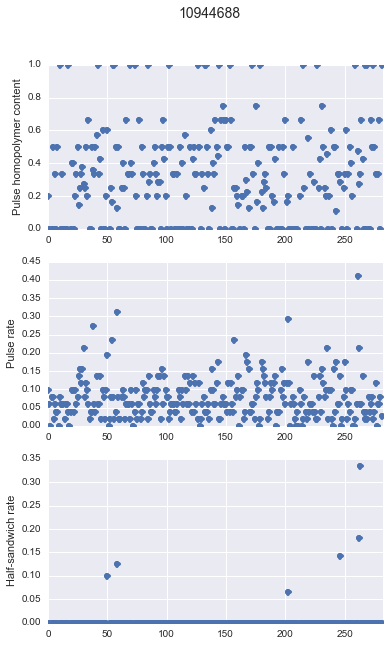

In [15]:
from ipywidgets import *

def plotMetricsP2(hnString):
    hn = int(hnString)
    basicActivityPlot(hn, fx)
    basicActivityPlot(hn, fx)

    print fx[hn].hqRegionSnr

# Let's look at hns with HQR but no alignment.
    
hnW = Select(options=map(str, fx.holeNumbers[:200]))

interact(plotMetricsP, hnString=hnW)

In [ ]:
def z():
    return fx[int(hnW.selected_label)]

In [ ]:
for aln in z().alignments:
    print aln.identity

In [ ]:
z().hqRegionSnr

In [8]:
hn = fx.holeNumbers[100]

In [9]:
%timeit len(fx[hn].baseRegions.hqRegion.extent)

1000 loops, best of 3: 475 µs per loop


In [10]:
%time
output = open("out.tsv", "w")

print >>output, "Hole SNR1 SNR2 SNR3 SNR4 HasAlignment"

for hn in fx.holeNumbers:
    z = fx[hn]    
    if len(z.baseRegions.hqRegion) > 0:
        hasAln = z.hasAlignments
        print >>output,  hn,
        for c in range(4):
            print >>output, z.hqRegionSnr[c],
        print >>output, hasAln
        
output.close()        
        

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [ ]:
missingZmws = set(fx.trcF.holeNumbers)-set(fx.basF.allSequencingZmws)

In [ ]:
missingZmws

In [16]:
fx

KeyError: "Unable to open object (File read failed: time = wed feb 10 20:14:38 2016\n, filename = '/pbi/collections/315/3150057/r54006_20160119_011818/2_b01/bz30019_x1e3_i0_plxbax/m54006_160119_063009.bax.h5', file descriptor = 84, errno = 5, error message = 'input/output error', buf = 0x7fff5746e740, total read size = 512, bytes this sub-read = 512, bytes actually read = 18446744073709551615, offset = 2344)"